In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
from ema_pytorch import EMA
from torch.distributions import Normal 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [2]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
class cde_ScoreNet(nn.Module):


  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):

    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, y, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    
    x = torch.hstack([x, y])
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
#@title Set up the SDE
import functools
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma_min, sigma_max):
    """Compute the standard deviation of $p_{0t}(x(t) | x(0))$.
    
    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t)
    std = sigma_min * (sigma_max / sigma_min) ** t
    return std

def diffusion_coeff(t, sigma_min, sigma_max):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    diffusion = sigma_min * (sigma_max / sigma_min) **t * \
        torch.sqrt(torch.tensor(2 * (np.log(sigma_max) - np.log(sigma_min))))
    return diffusion
  
sigma_min = 0.01
sigma_max = 25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma_min=sigma_min, sigma_max = sigma_max)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma_min=sigma_min, sigma_max = sigma_max)

In [4]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [12]:
#@title Training (double click to expand or collapse)

import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1000 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-7-c1991806c254>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


KeyboardInterrupt: 

In [5]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  1000
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           device='cpu',
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

In [6]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  1000
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cpu',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    # The last step does not include any noise
    return x_mean

In [7]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x


<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

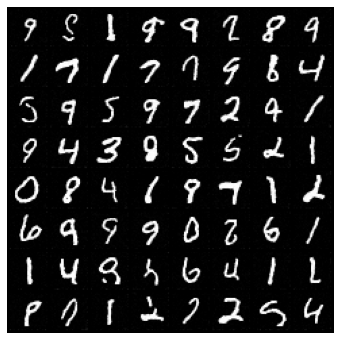

In [9]:
from torchvision.utils import make_grid


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

ckpt = torch.load('models/MNIST.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 
sampler = pc_sampler 

samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device,
                  num_steps=1000)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [12]:
data = MNIST('./data', train=True, transform=transforms.ToTensor())

In [25]:
zero = data[1][0][0]
three = data[7][0][0]

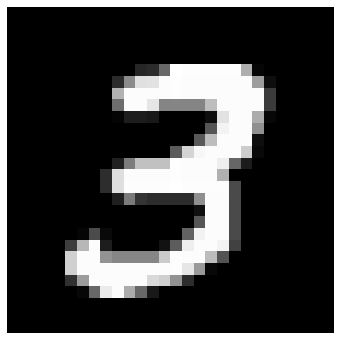

In [24]:
grid = make_grid(data[7][0], nrow=1)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [26]:
def sde_VE(x, t, sigma_min, sigma_max):
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
    drift = 0
    return drift, diffusion

In [27]:
def get_diffused(obs, n, sde, sigma_min, sigma_max):
    data = obs.clone().detach()
    t = 1e-5
    dt = 1/n
    diffused = [data.clone().detach()]
    for i in range(n):
        drift, diffusion = sde(data, t, sigma_min, sigma_max)
        data += drift * dt
        data += diffusion * torch.randn(28,28, device=device) * np.sqrt(dt)
        data = torch.clamp(data, 0, 1)
        diffused.append(data.clone().detach())
        t += dt
        
    return torch.stack(diffused)

In [28]:
def insert_condition(x, y_obs):
    inserted = x.clone().detach()

    for i in inserted:
        i[0][:, :14] = y_obs

    return inserted

In [29]:
diff = get_diffused(zero, 1000, sde_VE, sigma_min, sigma_max)

In [30]:
diff[0].shape

torch.Size([28, 28])

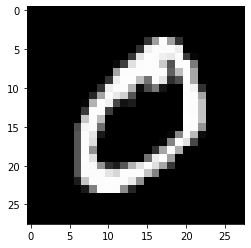

In [31]:
plt.imshow(make_grid(diff[0], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

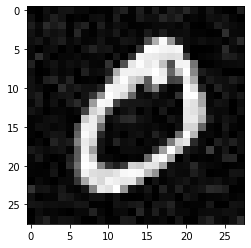

In [32]:
plt.imshow(make_grid(diff[250], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

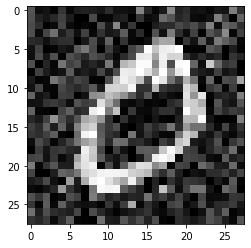

In [33]:
plt.imshow(make_grid(diff[400], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

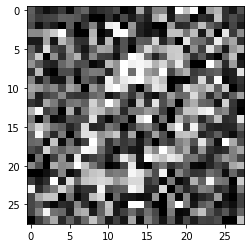

In [34]:
plt.imshow(make_grid(diff[500], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

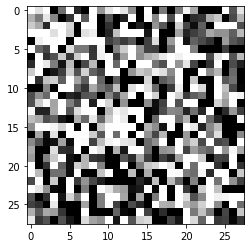

In [35]:
plt.imshow(make_grid(diff[750], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

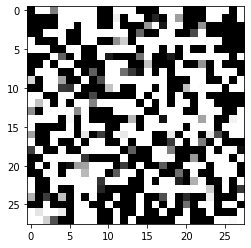

In [36]:
plt.imshow(make_grid(diff[1000], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [37]:
obs = diff[0][:,:14]

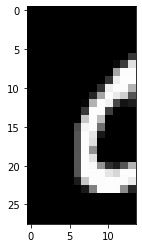

In [38]:
plt.imshow(make_grid(obs, nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

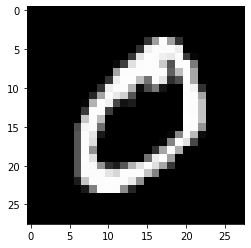

In [39]:
plt.imshow(make_grid(diff[0], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [40]:
def CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=16, 
                           num_steps=1000, 
                           eps=1e-3, sigma_min=sigma_min, sigma_max=sigma_max, diffused_y=None):

    t = torch.ones(batch_size, device=device)
    x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(1)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]

    if diffused_y is None:
        diffused_y = get_diffused(y_obs, 1000, sde_VE, sigma_min, sigma_max)
        diffused_y = [i[:,:14] for i in diffused_y]
    
    else:
        diffused_y = [i[:,:14] for i in diffused_y]

    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            x = insert_condition(x, y_obs_t)
            
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            

            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    return mean_x

In [41]:
def CDiffE_pc_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=16, 
                           num_steps=1000, 
                           eps=1e-3, sigma_min=sigma_min, sigma_max=sigma_max, diffused_y=None, snr=0.16):

    t = torch.ones(batch_size, device=device)
    x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(1)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]

    if diffused_y is None:
        diffused_y = get_diffused(y_obs, 1000, sde_VE, sigma_min, sigma_max)
        diffused_y = [i[:,:14] for i in diffused_y]
    
    else:
        diffused_y = [i[:,:14] for i in diffused_y]

    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            x = insert_condition(x, y_obs_t)
            batch_time_step = torch.ones(batch_size) * time_step
            
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            x = insert_condition(x, y_obs_t)
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    return mean_x

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


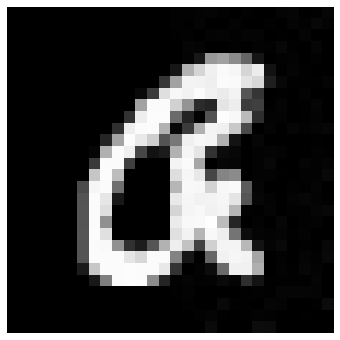

In [80]:
samples = CDiffE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = diff, batch_size=1)


samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


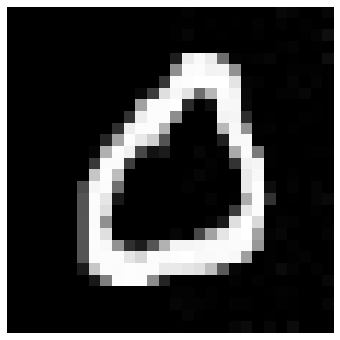

In [77]:
samples = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = diff, batch_size=1)


samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [44]:
three_diff = get_diffused(three, 1000, sde_VE, sigma_min, sigma_max)

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


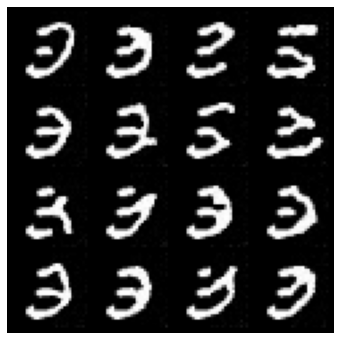

In [45]:
three_samples = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, three, diffused_y = three_diff)


three_samples = three_samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
three_sample_grid = make_grid(three_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(three_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [46]:
def systematic(W, M):
    """Systematic resampling.
    """
    su = (np.random.rand(1) + np.arange(M)) / M
    return inverse_cdf(su, W)

def multinomial(W, M):
    """Multinomial resampling.

    Popular resampling scheme, which amounts to sample N independently from
    the multinomial distribution that generates n with probability W^n. 

    This resampling scheme is *not* recommended for various reasons; basically
    schemes like stratified / systematic / SSP tends to introduce less noise,
    and may be faster too (in particular systematic). 
    """
    return inverse_cdf(uniform_spacings(M), W)

def uniform_spacings(N):
    """Generate ordered uniform variates in O(N) time.

    Parameters
    ----------
    N: int (>0)
        the expected number of uniform variates

    Returns
    -------
    (N,) float ndarray
        the N ordered variates (ascending order)

    Note
    ----
    This is equivalent to::

        from numpy import random
        u = sort(random.rand(N))

    but the line above has complexity O(N*log(N)), whereas the algorithm
    used here has complexity O(N).

    """
    z = np.cumsum(-np.log(np.random.rand(N + 1)))
    return z[:-1] / z[-1]

def inverse_cdf(su, W):
    """Inverse CDF algorithm for a finite distribution.

        Parameters
        ----------
        su: (M,) ndarray
            M sorted uniform variates (i.e. M ordered points in [0,1]).
        W: (N,) ndarray
            a vector of N normalized weights (>=0 and sum to one)

        Returns
        -------
        A: (M,) ndarray
            a vector of M indices in range 0, ..., N-1
    """
    j = 0
    s = W[0]
    M = su.shape[0]
    A = np.empty(M, dtype=np.int64)
    for n in range(M):
        while su[n] > s:
            if j < W.shape[0]-1:
                j += 1
            s += W[j]
        A[n] = j
    return A

In [67]:
def get_y(x, k):
    y = torch.zeros(k,1,28,14)
    for i in range(k):
        y[i][0] = x[i][0][:, :14]
        
    return y    

In [48]:
samples.shape

torch.Size([16, 1, 28, 28])

In [49]:
get_y(samples).shape

torch.Size([16, 1, 28, 14])

In [50]:
def log_imp_weights(sample, mean, sd):
    log_w = -(1./2)*(sample-mean)**2/(sd**2)
    log_w = torch.sum(log_w, axis=[1,2,3])
    log_w -= torch.logsumexp(log_w, 0)
    return log_w

In [51]:
log_imp_weights(samples,samples,1)

tensor([-2.7726, -2.7726, -2.7726, -2.7726, -2.7726, -2.7726, -2.7726, -2.7726,
        -2.7726, -2.7726, -2.7726, -2.7726, -2.7726, -2.7726, -2.7726, -2.7726])

In [93]:
def SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coeff, y_obs, k, num_steps=1000, 
                                       eps=1e-3, sigma_min=sigma_min, sigma_max=sigma_max, diffused_y=None):

    t = torch.ones(k, device=device)
    x = torch.randn(k, 1, 28, 28, device=device) * marginal_prob_std(1)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    weights = np.ones(k)/k
    
    if diffused_y is None:
        diffused_y = get_diffused(y_obs, 1000, sde_VE, sigma_min, sigma_max)
        diffused_y = [i[:,:14] for i in diffused_y]
    
    else:
        diffused_y = [i[:,:14] for i in diffused_y]

    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):

            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            x = insert_condition(x, y_obs_t)
            batch_time_step = torch.ones(k, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            
        
            if (idx - 1) >= 0:
                mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
                sd = torch.sqrt(step_size) * g[:, None, None, None]

                y_update_mean = get_y(mean_x, k)
                y_update_actual = diffused_y[idx-1]


                log_w = log_imp_weights(y_update_actual, y_update_mean, sd)
                weights *= torch.exp(log_w).cpu().detach().numpy()
                weights /= sum(weights) 
                
                departure_from_uniform = np.sum(abs(k*weights-1))
                if (departure_from_uniform > 0.75*k) and (idx>50):
                    print(idx, "resampling, departure=%0.02f"%departure_from_uniform)
                    resample_index = systematic(weights, k)
                    x = x[resample_index]
                    weights = np.ones_like(weights)/k
            
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
            
    return x

In [74]:
def SMCDiff_pc_sampler(score_model, marginal_prob_std, diffusion_coeff, y_obs, k, num_steps=1000, 
                                       eps=1e-3, sigma_min=sigma_min, sigma_max=sigma_max, diffused_y=None, snr=0.16):

    t = torch.ones(k, device=device)
    x = torch.randn(k, 1, 28, 28, device=device) * marginal_prob_std(1)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    
    weights = np.ones(k)/k
    
    if diffused_y is None:
        diffused_y = get_diffused(y_obs, 1000, sde_VE, sigma_min, sigma_max)
        diffused_y = [i[:,:14] for i in diffused_y]
    
    else:
        diffused_y = [i[:,:14] for i in diffused_y]

    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):

            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            x = insert_condition(x, y_obs_t)
            
            batch_time_step = torch.ones(k, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            
            
            #get predicted y_{t-1}
            if (idx - 1) >= 0:
                mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
                sd = torch.sqrt(step_size) * g

                y_update_mean = get_y(mean_x)
                y_update_actual = diffused_y[idx-1]


                log_w = log_imp_weights(y_update_actual, y_update_mean, sd)

                weights *= torch.exp(log_w).cpu().detach().numpy()
                weights /= sum(weights) 
                
                departure_from_uniform = np.sum(abs(k*weights-1))
                if (departure_from_uniform > 0.1*k) and (idx>50):
                    print(idx, "resampling, departure=%0.02f"%departure_from_uniform)
                    resample_index = systematic(weights, k)
                    x = x[resample_index]
                    weights = np.ones_like(weights)/k
                    
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            x = insert_condition(x, y_obs_t)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
            
    return x

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


987 resampling, departure=6.74
978 resampling, departure=7.37
972 resampling, departure=6.53
967 resampling, departure=6.56
962 resampling, departure=7.72
958 resampling, departure=6.86
953 resampling, departure=7.73
949 resampling, departure=7.86
946 resampling, departure=6.41
943 resampling, departure=6.88
939 resampling, departure=7.44
935 resampling, departure=7.89
932 resampling, departure=6.57
928 resampling, departure=8.60
925 resampling, departure=7.19
922 resampling, departure=7.93
919 resampling, departure=7.12
916 resampling, departure=7.38
913 resampling, departure=7.62
910 resampling, departure=8.86
907 resampling, departure=8.05
904 resampling, departure=8.10
901 resampling, departure=8.22
899 resampling, departure=6.70
897 resampling, departure=6.54
895 resampling, departure=6.90
892 resampling, departure=9.56
889 resampling, departure=10.25
887 resampling, departure=7.43
885 resampling, departure=7.05
883 resampling, departure=6.89
881 resampling, departure=7.88
879 res

498 resampling, departure=13.40
497 resampling, departure=6.71
495 resampling, departure=15.28
494 resampling, departure=9.03
493 resampling, departure=6.84
492 resampling, departure=10.23
491 resampling, departure=10.99
490 resampling, departure=9.34
489 resampling, departure=10.95
488 resampling, departure=8.77
487 resampling, departure=8.71
486 resampling, departure=7.57
485 resampling, departure=7.55
484 resampling, departure=16.25
482 resampling, departure=10.08
481 resampling, departure=7.05
480 resampling, departure=7.95
479 resampling, departure=10.89
478 resampling, departure=9.63
477 resampling, departure=11.25
476 resampling, departure=13.36
475 resampling, departure=10.65
474 resampling, departure=7.21
473 resampling, departure=10.34
472 resampling, departure=7.28
470 resampling, departure=11.73
468 resampling, departure=9.85
467 resampling, departure=8.68
465 resampling, departure=16.53
464 resampling, departure=7.86
463 resampling, departure=7.03
462 resampling, departure

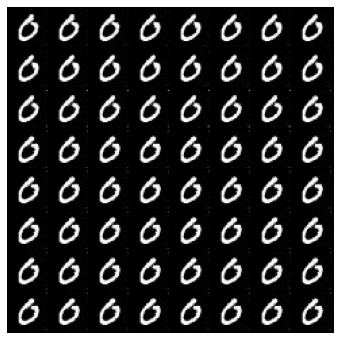

In [75]:
samples = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                         zero, diffused_y = diff, k=64)

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(64)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


954 resampling, departure=48.26
927 resampling, departure=48.99
907 resampling, departure=48.17
892 resampling, departure=48.20
878 resampling, departure=49.13
862 resampling, departure=48.53
846 resampling, departure=49.39
830 resampling, departure=49.71
818 resampling, departure=49.44
808 resampling, departure=48.90
798 resampling, departure=48.41
786 resampling, departure=50.68
771 resampling, departure=50.42
757 resampling, departure=50.51
742 resampling, departure=50.73
732 resampling, departure=53.53
718 resampling, departure=48.21
690 resampling, departure=50.04
652 resampling, departure=48.51
615 resampling, departure=48.56
579 resampling, departure=48.30
557 resampling, departure=49.35
542 resampling, departure=53.09
528 resampling, departure=49.21
521 resampling, departure=55.03
518 resampling, departure=53.34
506 resampling, departure=49.49
487 resampling, departure=50.46
460 resampling, departure=50.41
432 resampling, departure=50.92
407 resampling, departure=50.91
360 resa

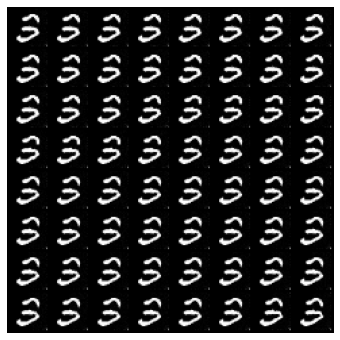

In [70]:
samples = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                         three, diffused_y = three_diff, k=64)


samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(64)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [81]:
zero_diffs = [get_diffused(zero, 1000, sde_VE, sigma_min, sigma_max) for i in range(16)]

In [88]:
cdiffe_sample = CDiffE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diffs[0], batch_size=1)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


In [89]:
for i in range(1,16):
    sample = CDiffE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diffs[i], batch_size=1)
    cdiffe_sample = torch.vstack([cdiffe_sample, sample])

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

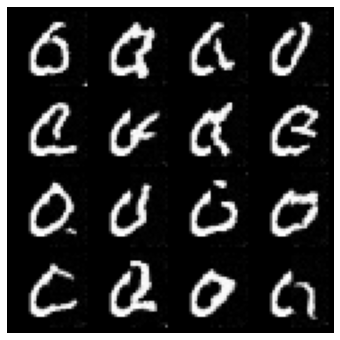

In [90]:
cdiffe_sample = cdiffe_sample.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(cdiffe_sample, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [94]:
smcdiff_sample = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diffs[0], k=16)[0]


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


953 resampling, departure=12.12
930 resampling, departure=12.22
915 resampling, departure=12.11
893 resampling, departure=12.41
879 resampling, departure=12.39
866 resampling, departure=12.20
846 resampling, departure=12.41
832 resampling, departure=12.43
815 resampling, departure=12.48
784 resampling, departure=12.03
771 resampling, departure=12.97
756 resampling, departure=12.23
729 resampling, departure=12.44
702 resampling, departure=12.25
659 resampling, departure=12.05
616 resampling, departure=12.10
589 resampling, departure=12.36
563 resampling, departure=12.37
538 resampling, departure=12.61
525 resampling, departure=13.14
511 resampling, departure=12.17
490 resampling, departure=12.83
475 resampling, departure=12.91
444 resampling, departure=12.99
381 resampling, departure=12.52
351 resampling, departure=12.04
337 resampling, departure=12.35
284 resampling, departure=12.24
231 resampling, departure=12.36
167 resampling, departure=12.26
118 resampling, departure=12.09
79 resam

In [95]:
for i in rangesmcdiff_sample(1,16):
    sample = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diffs[i], k=16)[0]
    smcdiff_sample = torch.vstack([smcdiff_sample, sample])
    
smcdiff_sample = smcdiff_sample[:,None,:,:]

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


939 resampling, departure=12.07
907 resampling, departure=12.04
893 resampling, departure=12.06
880 resampling, departure=12.59
862 resampling, departure=12.02
843 resampling, departure=12.18
828 resampling, departure=12.52
803 resampling, departure=12.01
787 resampling, departure=12.08
774 resampling, departure=12.18
754 resampling, departure=12.46
740 resampling, departure=13.01
725 resampling, departure=12.10
639 resampling, departure=12.25
600 resampling, departure=12.26
571 resampling, departure=12.01
567 resampling, departure=12.14
552 resampling, departure=13.44
517 resampling, departure=12.01
486 resampling, departure=12.11
469 resampling, departure=12.45
443 resampling, departure=12.46
407 resampling, departure=13.23
390 resampling, departure=12.24
359 resampling, departure=12.59
292 resampling, departure=12.15
258 resampling, departure=12.06
224 resampling, departure=12.15
158 resampling, departure=12.45
124 resampling, departure=12.21
94 resampling, departure=13.01
63 resamp

  0%|          | 0/1000 [00:00<?, ?it/s]

940 resampling, departure=12.12
915 resampling, departure=12.00
899 resampling, departure=12.21
885 resampling, departure=12.08
869 resampling, departure=12.71
852 resampling, departure=12.02
841 resampling, departure=12.15
823 resampling, departure=12.08
807 resampling, departure=12.41
788 resampling, departure=12.71
780 resampling, departure=12.57
765 resampling, departure=12.07
754 resampling, departure=12.13
735 resampling, departure=12.44
721 resampling, departure=12.28
701 resampling, departure=12.01
672 resampling, departure=12.31
628 resampling, departure=12.35
601 resampling, departure=12.45
568 resampling, departure=13.19
556 resampling, departure=12.95
542 resampling, departure=12.71
497 resampling, departure=12.21
478 resampling, departure=12.47
472 resampling, departure=12.33
431 resampling, departure=13.36
354 resampling, departure=12.06
309 resampling, departure=12.20
263 resampling, departure=12.07
214 resampling, departure=12.56
138 resampling, departure=12.17
94 resam

  0%|          | 0/1000 [00:00<?, ?it/s]

948 resampling, departure=12.25
918 resampling, departure=12.10
894 resampling, departure=12.16
878 resampling, departure=12.48
868 resampling, departure=12.71
854 resampling, departure=12.40
841 resampling, departure=12.45
821 resampling, departure=12.08
805 resampling, departure=12.54
794 resampling, departure=12.36
782 resampling, departure=12.86
767 resampling, departure=12.48
749 resampling, departure=12.49
733 resampling, departure=13.09
692 resampling, departure=12.21
659 resampling, departure=12.18
603 resampling, departure=12.68
547 resampling, departure=13.26
542 resampling, departure=12.21
531 resampling, departure=12.73
528 resampling, departure=12.33
511 resampling, departure=13.08
507 resampling, departure=12.08
485 resampling, departure=13.56
481 resampling, departure=13.43
476 resampling, departure=13.66
464 resampling, departure=12.11
399 resampling, departure=12.35
353 resampling, departure=12.03
311 resampling, departure=12.07
263 resampling, departure=12.26
176 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

953 resampling, departure=12.26
938 resampling, departure=12.63
923 resampling, departure=12.64
909 resampling, departure=12.19
884 resampling, departure=12.25
863 resampling, departure=12.12
837 resampling, departure=12.30
823 resampling, departure=12.27
806 resampling, departure=12.40
782 resampling, departure=12.27
769 resampling, departure=12.61
755 resampling, departure=12.51
739 resampling, departure=12.19
721 resampling, departure=12.09
698 resampling, departure=12.10
659 resampling, departure=12.45
624 resampling, departure=12.06
598 resampling, departure=12.25
569 resampling, departure=12.22
537 resampling, departure=13.76
490 resampling, departure=14.12
471 resampling, departure=12.31
441 resampling, departure=12.38
411 resampling, departure=13.05
340 resampling, departure=12.44
232 resampling, departure=12.19
145 resampling, departure=12.55
127 resampling, departure=12.96
79 resampling, departure=12.05


  0%|          | 0/1000 [00:00<?, ?it/s]

955 resampling, departure=12.05
929 resampling, departure=12.42
913 resampling, departure=12.15
897 resampling, departure=12.37
885 resampling, departure=12.56
867 resampling, departure=12.38
851 resampling, departure=12.35
839 resampling, departure=12.52
830 resampling, departure=12.03
813 resampling, departure=12.34
797 resampling, departure=12.47
784 resampling, departure=12.87
771 resampling, departure=12.77
760 resampling, departure=12.49
745 resampling, departure=12.04
718 resampling, departure=12.13
675 resampling, departure=12.13
621 resampling, departure=12.01
582 resampling, departure=12.53
564 resampling, departure=13.24
544 resampling, departure=12.02
485 resampling, departure=12.91
460 resampling, departure=12.77
421 resampling, departure=12.08
390 resampling, departure=12.68
381 resampling, departure=13.54
357 resampling, departure=12.19
312 resampling, departure=12.94
275 resampling, departure=12.16
245 resampling, departure=12.18
176 resampling, departure=12.47
144 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

954 resampling, departure=12.16
940 resampling, departure=12.67
923 resampling, departure=12.14
905 resampling, departure=12.33
892 resampling, departure=12.17
877 resampling, departure=12.02
863 resampling, departure=12.04
847 resampling, departure=12.74
833 resampling, departure=12.03
816 resampling, departure=12.55
805 resampling, departure=12.03
795 resampling, departure=12.15
782 resampling, departure=12.08
772 resampling, departure=12.42
764 resampling, departure=12.67
743 resampling, departure=12.36
721 resampling, departure=12.23
699 resampling, departure=12.27
655 resampling, departure=12.16
619 resampling, departure=12.60
599 resampling, departure=13.52
582 resampling, departure=12.27
566 resampling, departure=12.22
539 resampling, departure=13.58
530 resampling, departure=13.67
513 resampling, departure=12.74
501 resampling, departure=12.97
495 resampling, departure=12.12
490 resampling, departure=12.31
447 resampling, departure=12.33
406 resampling, departure=12.77
394 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

939 resampling, departure=12.03
917 resampling, departure=12.04
896 resampling, departure=12.89
878 resampling, departure=12.36
858 resampling, departure=12.11
847 resampling, departure=13.16
830 resampling, departure=12.12
814 resampling, departure=12.46
791 resampling, departure=12.30
780 resampling, departure=12.26
767 resampling, departure=12.30
752 resampling, departure=12.33
740 resampling, departure=12.78
723 resampling, departure=12.41
691 resampling, departure=12.01
670 resampling, departure=12.95
650 resampling, departure=12.01
630 resampling, departure=13.15
590 resampling, departure=12.06
568 resampling, departure=13.26
544 resampling, departure=12.22
503 resampling, departure=13.19
483 resampling, departure=12.68
457 resampling, departure=12.12
452 resampling, departure=13.21
434 resampling, departure=12.31
414 resampling, departure=14.99
386 resampling, departure=12.21
349 resampling, departure=12.08
305 resampling, departure=12.72
266 resampling, departure=12.36
171 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

954 resampling, departure=12.13
924 resampling, departure=12.55
902 resampling, departure=12.34
878 resampling, departure=12.29
863 resampling, departure=12.70
850 resampling, departure=12.66
833 resampling, departure=12.44
824 resampling, departure=13.06
814 resampling, departure=12.33
798 resampling, departure=12.88
781 resampling, departure=12.06
758 resampling, departure=12.41
745 resampling, departure=12.83
734 resampling, departure=12.69
716 resampling, departure=12.15
697 resampling, departure=12.41
663 resampling, departure=12.36
626 resampling, departure=12.13
571 resampling, departure=12.11
562 resampling, departure=13.53
552 resampling, departure=12.21
529 resampling, departure=12.10
490 resampling, departure=14.70
480 resampling, departure=13.01
459 resampling, departure=12.13
448 resampling, departure=12.66
421 resampling, departure=12.29
415 resampling, departure=12.94
394 resampling, departure=12.19
337 resampling, departure=12.74
264 resampling, departure=12.46
237 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

941 resampling, departure=12.06
922 resampling, departure=12.59
902 resampling, departure=12.55
882 resampling, departure=12.02
859 resampling, departure=12.37
835 resampling, departure=12.55
815 resampling, departure=12.74
803 resampling, departure=12.86
795 resampling, departure=12.59
787 resampling, departure=12.16
774 resampling, departure=12.36
757 resampling, departure=12.27
739 resampling, departure=12.24
726 resampling, departure=12.03
709 resampling, departure=12.18
693 resampling, departure=12.06
666 resampling, departure=12.01
607 resampling, departure=13.42
588 resampling, departure=12.01
562 resampling, departure=13.34
541 resampling, departure=12.94
535 resampling, departure=13.80
527 resampling, departure=12.97
514 resampling, departure=12.38
496 resampling, departure=12.57
488 resampling, departure=13.08
479 resampling, departure=12.94
468 resampling, departure=12.39
448 resampling, departure=14.45
444 resampling, departure=12.22
398 resampling, departure=12.27
355 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

940 resampling, departure=12.29
910 resampling, departure=12.37
887 resampling, departure=12.60
873 resampling, departure=12.33
829 resampling, departure=12.14
811 resampling, departure=12.02
791 resampling, departure=12.19
770 resampling, departure=12.40
756 resampling, departure=12.46
740 resampling, departure=12.39
725 resampling, departure=12.62
707 resampling, departure=12.54
663 resampling, departure=12.45
619 resampling, departure=12.03
598 resampling, departure=12.66
545 resampling, departure=12.35
531 resampling, departure=12.96
517 resampling, departure=12.08
505 resampling, departure=12.05
482 resampling, departure=13.48
479 resampling, departure=12.85
472 resampling, departure=12.38
461 resampling, departure=12.59
447 resampling, departure=13.60
422 resampling, departure=12.40
362 resampling, departure=12.88
311 resampling, departure=12.16
261 resampling, departure=12.24
245 resampling, departure=12.57
210 resampling, departure=13.20
153 resampling, departure=12.52
119 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

945 resampling, departure=12.07
907 resampling, departure=12.07
886 resampling, departure=12.48
861 resampling, departure=12.01
844 resampling, departure=12.25
827 resampling, departure=12.42
811 resampling, departure=12.07
799 resampling, departure=12.46
785 resampling, departure=12.48
767 resampling, departure=12.59
752 resampling, departure=12.03
723 resampling, departure=12.05
697 resampling, departure=12.04
660 resampling, departure=12.57
602 resampling, departure=14.69
572 resampling, departure=12.33
532 resampling, departure=12.19
503 resampling, departure=12.19
486 resampling, departure=12.43
477 resampling, departure=14.55
438 resampling, departure=14.15
383 resampling, departure=13.02
348 resampling, departure=12.77
296 resampling, departure=13.19
211 resampling, departure=12.65
125 resampling, departure=13.19
88 resampling, departure=12.22
68 resampling, departure=12.20


  0%|          | 0/1000 [00:00<?, ?it/s]

942 resampling, departure=12.03
907 resampling, departure=12.29
885 resampling, departure=12.72
869 resampling, departure=12.44
857 resampling, departure=12.21
846 resampling, departure=12.03
836 resampling, departure=12.62
826 resampling, departure=12.56
816 resampling, departure=12.06
803 resampling, departure=13.01
775 resampling, departure=12.32
756 resampling, departure=12.95
738 resampling, departure=12.18
707 resampling, departure=12.24
664 resampling, departure=12.29
615 resampling, departure=12.42
573 resampling, departure=12.32
558 resampling, departure=12.54
541 resampling, departure=12.35
536 resampling, departure=12.94
521 resampling, departure=12.43
488 resampling, departure=12.42
477 resampling, departure=12.32
455 resampling, departure=12.72
418 resampling, departure=12.08
383 resampling, departure=12.11
329 resampling, departure=12.23
277 resampling, departure=12.07
169 resampling, departure=12.57
134 resampling, departure=12.21
99 resampling, departure=12.50
68 resamp

  0%|          | 0/1000 [00:00<?, ?it/s]

949 resampling, departure=12.06
920 resampling, departure=12.14
903 resampling, departure=12.26
886 resampling, departure=12.60
867 resampling, departure=12.41
849 resampling, departure=12.42
833 resampling, departure=12.68
818 resampling, departure=12.25
807 resampling, departure=12.20
792 resampling, departure=12.06
777 resampling, departure=12.07
759 resampling, departure=12.92
741 resampling, departure=12.97
719 resampling, departure=12.10
691 resampling, departure=12.22
654 resampling, departure=12.04
614 resampling, departure=12.09
559 resampling, departure=12.26
543 resampling, departure=14.74
513 resampling, departure=13.11
484 resampling, departure=12.72
451 resampling, departure=12.16
417 resampling, departure=13.17
351 resampling, departure=13.65
313 resampling, departure=12.64
275 resampling, departure=12.32
169 resampling, departure=12.07
127 resampling, departure=12.65
92 resampling, departure=12.07
65 resampling, departure=12.50


  0%|          | 0/1000 [00:00<?, ?it/s]

938 resampling, departure=12.21
913 resampling, departure=12.25
894 resampling, departure=12.19
872 resampling, departure=12.33
853 resampling, departure=12.28
838 resampling, departure=12.01
821 resampling, departure=12.30
805 resampling, departure=12.54
787 resampling, departure=12.05
772 resampling, departure=12.30
760 resampling, departure=12.04
734 resampling, departure=12.04
698 resampling, departure=12.25
665 resampling, departure=12.53
635 resampling, departure=12.21
601 resampling, departure=12.67
586 resampling, departure=15.30
578 resampling, departure=16.18
560 resampling, departure=12.09
533 resampling, departure=12.04
511 resampling, departure=12.26
492 resampling, departure=12.83
480 resampling, departure=13.35
472 resampling, departure=13.18
434 resampling, departure=12.15
392 resampling, departure=12.81
333 resampling, departure=12.09
304 resampling, departure=12.24
228 resampling, departure=12.11
133 resampling, departure=12.08
99 resampling, departure=12.41
57 resamp

  0%|          | 0/1000 [00:00<?, ?it/s]

915 resampling, departure=12.15
891 resampling, departure=12.40
878 resampling, departure=12.06
861 resampling, departure=12.08
831 resampling, departure=12.46
819 resampling, departure=13.01
808 resampling, departure=12.33
790 resampling, departure=12.81
772 resampling, departure=12.50
757 resampling, departure=12.43
743 resampling, departure=12.08
728 resampling, departure=12.96
690 resampling, departure=12.19
664 resampling, departure=12.26
628 resampling, departure=12.10
602 resampling, departure=12.92
572 resampling, departure=13.04
537 resampling, departure=12.86
517 resampling, departure=12.39
510 resampling, departure=12.39
499 resampling, departure=12.54
472 resampling, departure=13.20
456 resampling, departure=12.16
442 resampling, departure=12.66
419 resampling, departure=16.72
382 resampling, departure=13.58
376 resampling, departure=12.97
321 resampling, departure=12.44
294 resampling, departure=12.59
250 resampling, departure=12.08
172 resampling, departure=12.79
126 resa

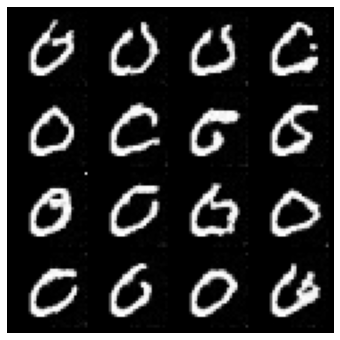

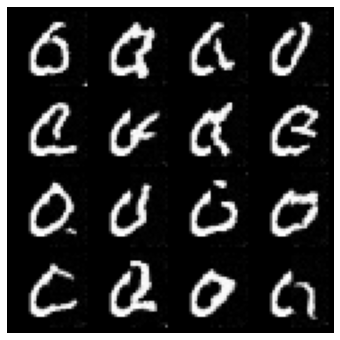

In [103]:
smcdiff_sample = smcdiff_sample.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
smcdiff_sample_grid = make_grid(smcdiff_sample, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(smcdiff_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

cdiffe_sample = cdiffe_sample.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(cdiffe_sample, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [104]:
torch.save(smcdiff_sample, 'data/smcdiff_zero.pt')

In [105]:
torch.save(cdiffe_sample, 'data/cdiffe_zero.pt')

In [98]:
SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diffs[i], k=16).shape

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


937 resampling, departure=12.40
909 resampling, departure=12.33
889 resampling, departure=12.05
871 resampling, departure=12.09
851 resampling, departure=13.06
843 resampling, departure=12.44
827 resampling, departure=12.41
801 resampling, departure=12.37
791 resampling, departure=12.24
784 resampling, departure=13.44
770 resampling, departure=13.04
753 resampling, departure=12.09
742 resampling, departure=12.06
697 resampling, departure=12.15
655 resampling, departure=12.17
623 resampling, departure=12.31
606 resampling, departure=14.20
567 resampling, departure=12.80
544 resampling, departure=15.18
509 resampling, departure=13.55
488 resampling, departure=12.44
478 resampling, departure=12.69
468 resampling, departure=15.48
440 resampling, departure=13.18
414 resampling, departure=12.08
367 resampling, departure=12.62
336 resampling, departure=12.17
310 resampling, departure=12.30
247 resampling, departure=12.09
128 resampling, departure=12.05
112 resampling, departure=12.51
79 resam

torch.Size([16, 1, 28, 28])